What is the name of your file? abc
What do you want to call your new file? aa
                              cond1     cond2  cond3
Glycolysis / Gluconeogenesis    5.0  4.666667    8.0
TCA                             6.0  1.000000    1.0
What do you want to name the graph? asdasdasd


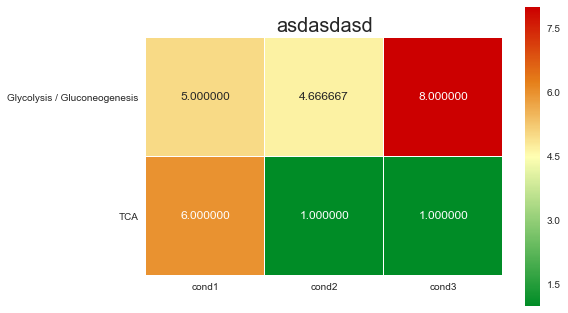

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os.path
import matplotlib.colors as colors

#extracting microarray file, indexing by gene
filename = input("What is the name of your file? ")
filename = filename + ".xlsx"
Sheets_Data = pd.ExcelFile(filename)
Microarray_Data = Sheets_Data.parse(0)
Microarray_Data.drop_duplicates(subset=['gene'],inplace = True)
Microarray_Data.index = Microarray_Data['gene']
Microarray_Data.drop(['gene'],inplace = True,axis=1)

#converting dataframe into quick access dictionary
Gene_to_Condition_Data = Microarray_Data.transpose().to_dict()

#grouping genes by pathway
cols = ['Pathway', 'Gene'] + list(Microarray_Data.columns.values)
Data_By_Path = pd.DataFrame(columns=cols)
for pathway_number in range(10,5300):
    datafile_name = "Pathway_" + str(pathway_number) + ".csv"
    
    #Check if the file exists
    if os.path.isfile(datafile_name):
        Path = []
        Pathway_Genes = pd.read_csv(datafile_name, na_values = [None,'NaN','Nothing'],
                              header = 0)
        
        #connect gene names of each pathway to the values connected to each condition
        for gene in Pathway_Genes.columns.values:
            if gene in Gene_to_Condition_Data.keys():
                gene_data = [Pathway_Genes.columns.values[0], gene]
                
                #attach each condition in microarray to data of the gene
                for condition in Gene_to_Condition_Data[gene].keys():
                    gene_data = gene_data + [Gene_to_Condition_Data[gene][condition]]
                Path.append(gene_data)
                
        #Attach each pathway to a cumulative list
        if (len(Path) >= 1):
            Path = pd.DataFrame(Path)
            Path.columns = cols
            Data_By_Path = [Data_By_Path, Path]
            Data_By_Path = pd.concat(Data_By_Path)

#index by point of entry in dataset
Data_By_Path.index = range(Data_By_Path.shape[0])

#Output a csv file of the data separated by pathway
filename = input("What do you want to call your new file? ")
Data_By_Path.to_csv(filename+".csv")

#Making a heatmap of genetic pathways by mean expression in each condition
Heatmap_Data = []
Homogeneity_Data = []
Normality_Data = []
#splitting data by pathway
Genetic_Data_Paths = Data_By_Path.groupby(['Pathway'])
for pathways in Genetic_Data_Paths.groups:
    for conditions in list(Microarray_Data.columns.values):
        Heatmap_Data.append(Genetic_Data_Paths.get_group(pathways)[conditions].mean())

#Configuring Data for heatmap
Heatmap_Data = np.array(Heatmap_Data)
Heatmap_Data = np.resize(Heatmap_Data, (Genetic_Data_Paths.ngroups,len(Microarray_Data.columns)))
Heatmap_Data = pd.DataFrame(Heatmap_Data)
Heatmap_Data.columns = Microarray_Data.columns.values
Heatmap_Data.index = Genetic_Data_Paths.groups
print(Heatmap_Data)

#Creating Green, yellow, red colormap
#color dictionary - be careful when changing this
cdict = {'green':  ((0.0, 0.55, 0.55),   # darker green at 0
                  (0.5, 1.0, 1.0),   # yellow hue
                  (0.75, 0.5, 0.5),  # avoid ugly brown color
                  (1.0, 0.0, 0.0)),  # no green at 1

        'red': ((0.0, 0.0, 0.0),   # no red at 0
                  (0.5, 1.0, 1.0),   # yellow hue
                  (0.75, 0.9, 0.9),  #avoid ugly brown color
                  (1.0, 0.8, 0.8)),  # bright-ish red at 1

        'blue':  ((0.0, 0.15, 0.15),   # slight blue at 0
                  (0.5, 0.7, 0.7),   # yellow hue
                  (0.75, 0.1, 0.1),  #avoid ugly brown color
                  (1.0, 0.0, 0.0))   # no blue at 1
       }
GnYlRd = colors.LinearSegmentedColormap('GnYlRd',cdict)

#display Heatmap
Heatmap = sns.heatmap(Heatmap_Data, cmap = GnYlRd, linewidth = 0.01,
                      annot=True, fmt = "f", square = True)
title = input("What do you want to name the graph? ")
plt.title(title, fontsize = 20)
plt.yticks(rotation = "horizontal")
plt.show()